# Convolutional Neural Network with Keras API

In [1]:
# OS ops and clocking progress
import os
import sys
import pickle
from datetime import datetime as dt

# Tensorflow, numpy and matplotlib imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Keras API
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Input, InputLayer
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


### Loading dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data


save_dir = '../saved/convnet/keras'
data_dir = '../datasets/MNIST'
saved_data = os.path.join(save_dir, f'data/{os.path.basename(data_dir)}.pkl')

if not os.path.isfile(saved_data):
    start = dt.now()
    data = input_data.read_data_sets(data_dir, one_hot=True)
    print(f'Took {dt.now() - start}')
    if not os.path.exists(os.path.dirname(saved_data)):
        os.makedirs(os.path.dirname(saved_data))
    pickle.dump(file=open(saved_data, 'wb'), obj=data)
    
    print('\nCached data for future use.')
else:
    start = dt.now()
    data = pickle.load(file=open(saved_data, 'rb'))
    print('Loaded cached data.')
    print(f'Took {dt.now() - start}')

data.test.cls = np.argmax(data.test.labels, axis=1)

# free memory
del start

Extracting ../datasets/MNIST/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/t10k-labels-idx1-ubyte.gz
Took 0:00:00.598211

Cached data for future use.


### Hyperparameters

In [3]:
# Data dimension
img_channel = 1
img_size = 28
img_size_flat = img_size * img_size * img_channel
num_classes = 10

# Network
kernel_size = 5
filter_1 = 32
filter_2 = 64
fc_size = 256
dropout = 0.8

# Training
train_batch = 100
test_batch = 50
val_batch = 25
learning_rate = 1e-2
n_iters = 0  # Total number of completed optimization iterations
save_interval = 100

### Visualization Helper functions

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape([img_size, img_size]), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle('Metrics')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.test.cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

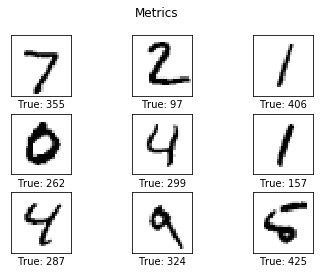

In [5]:
imgs = data.test.images[:9]
data_test = np.argmax(imgs, axis=1)
plot_images(images=imgs, cls_true=data_test)

### The Keras Convolutional Network

In [6]:
model = Sequential()
model.add(InputLayer(input_shape=[img_size_flat]))
model.add(Reshape([img_size, img_size, img_channel]))
# First convolutional layer
model.add(Conv2D(filters=filter_1, kernel_size=kernel_size, 
                 strides=1, padding='same', activation='relu', 
                 name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))
# Second convolutional layer
model.add(Conv2D(filters=filter_2, kernel_size=kernel_size,
                 strides=1, padding='same', activation='relu',
                 name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))
# Flatten
model.add(Flatten())
# Fully connected layer
model.add(Dense(units=fc_size, activation='relu'))
# Output layer
model.add(Dense(units=num_classes, activation='softmax'))

### Optimizer and Compilation

In [7]:
optimizer = Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### Training

In [8]:
model.fit(x=data.train.images, y=data.train.labels, epochs=1, batch_size=train_batch)

Epoch 1/1
55000/55000 [==============================] - 161s - loss: 0.1785 - acc: 0.9447     

### Evaluation

In [9]:
result = model.evaluate(x=data.test.images, y=data.test.labels)

10000/10000 [==============================] - 10s     

In [11]:
for name, value in zip(model.metrics_names, result):
    print(f'{name.title()}: {value:.2%}')

Loss: 7.08%
Acc: 97.83%


### Prediction

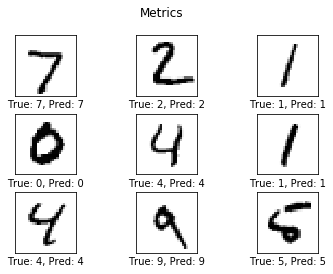

In [12]:
imgs = data.test.images[0:9]
cls_true = data.test.cls[0:9]
# Keras Predict API
y_pred = model.predict(x=imgs)
cls_pred = np.argmax(y_pred, axis=1)
plot_images(imgs, cls_true=cls_true, cls_pred=cls_pred)

### Mis classifications

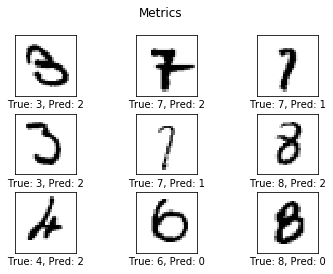

In [13]:
y_pred = model.predict(x=data.test.images)
cls_pred = np.argmax(y_pred, axis=1)

plot_example_errors(cls_pred)

## Keras Function Model

In [14]:
# input layer
net = Input(shape=[img_size_flat])
inputs = net
net = Reshape([img_size, img_size, img_channel])(net)
# first convolutional layer
net = Conv2D(filters=filter_1, kernel_size=kernel_size, 
             strides=1, padding='same', activation='relu', 
             name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
# second convolutional layer
net = Conv2D(filters=filter_2, kernel_size=kernel_size,
             strides=1, padding='same', activation='relu',
             name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
# flatten layer
net = Flatten()(net)
# Fully connected layer
net = Dense(units=fc_size, activation='relu')(net)
# Output layer
net = Dense(units=num_classes, activation='softmax')(net)
outputs = net

### Model creatiion and compilation

In [15]:
model2 = Model(inputs=inputs, outputs=outputs)

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Training

In [16]:
model2.fit(x=data.train.images, y=data.train.labels, epochs=1, batch_size=train_batch)

Epoch 1/1
55000/55000 [==============================] - 166s - loss: 0.1470 - acc: 0.9533     

### Evaluation

In [17]:
result = model2.evaluate(x=data.test.images, y=data.test.labels)

 9984/10000 [============================>.] - ETA: 0s 

In [18]:
for name, value in zip(model2.metrics_names, result):
    print(f'{name.title()}: {value:.2%}')

Loss: 4.57%
Acc: 98.39%


### Mis classification

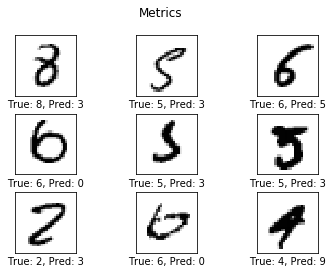

In [19]:
y_pred = model2.predict(x=data.test.images)
cls_pred = np.argmax(y_pred, axis=1)

plot_example_errors(cls_pred)

## Saving & Loading Model

In [20]:
model_path = os.path.join(save_dir, 'model.keras')
model2.save(model_path)

del model2  # delete model2 from disk

### loading model

In [21]:
model3 = load_model(model_path)

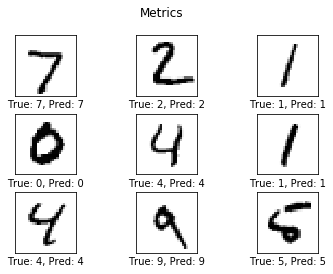

In [22]:
# Prediction
imgs = data.test.images[:9]
cls_true = data.test.cls[:9]

y_pred = model3.predict(x=imgs)
cls_pred = np.argmax(y_pred, axis=1)

plot_images(imgs, cls_true, cls_pred)

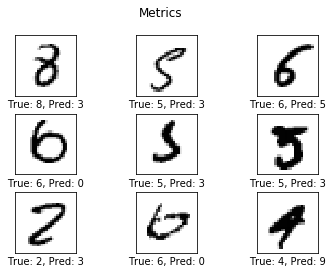

In [23]:
# Plotting mis-classified data
y_pred = model3.predict(x=data.test.images)
cls_pred = np.argmax(y_pred, axis=1)

plot_example_errors(cls_pred)

### Summary

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [25]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
__________